## 빅데이터 활용 AI 설계
# AutoEncoder : VAE
- 케라스 창시자에게 배우는 딥러닝 8.4절
- 원본 이미지로 매핑될 수 있는 저차원 잠재공간(벡터공간)의 표현을 만든다
- 인코더의 출력이 저차원이고 희소하도록 제약을 가하여 원본이미지를 압축한다

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### MNIST 로딩

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
X_train = np.expand_dims(X_train/255., axis=-1) # X_train[:,:,:,np.newaxis]
X_test = np.expand_dims(X_test/255., axis=-1)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### 인코더 생성
- 잠재차원을 2차원으로 만든다.
- 각 차원별로 평균과 분산의 값을 얻는다.
- 이 평균과 분산을 가지고 최종적으로 2차원 벡터값을 얻는다.
> z_mean + epsilon * exp(z_log_var/2)

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, \
    Lambda, Reshape, Conv2DTranspose, Layer

In [6]:
input = Input(shape=(28,28,1))

x = Conv2D(32, (3,3), padding='same', activation='relu')(input)
x = Conv2D(64, (3,3), padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(input)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(2)(x) # 잠재차원이 2차원이다.
z_log_var = Dense(2)(x) # 즉, 각 차원별로 평균과 로그분산을 얻는다.

In [7]:
from keras import backend as K

In [8]:
def sampling_lambda(args):
    z_maen, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],2), mean=0., stddev=1.)
        # K.shape(z_mean)[0] 는 샘플의 갯수를 의미함
    return z_mean + K.exp(0.5 * z_log_var)*epsilon
    
z = Lambda(sampling_lambda)([z_mean, z_log_var])

In [9]:
z

<tf.Tensor 'lambda_1/add:0' shape=(?, 2) dtype=float32>

### 디코더 설정

In [10]:
input2 = Input(shape=(2,))

x2 = Dense(14*14*64, activation='relu')(input2)
x2 = Reshape((14,14,64))(x2)
x2 = Conv2DTranspose(32, (3,3), padding='same', activation='relu', strides=(2,2))(x2)
x2 = Conv2DTranspose(1, (3,3), padding='same', activation='sigmoid')(x2)

In [11]:
decoder = Model(input2, x2)

In [12]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


### 손실값 정의
- reconstruction loss : 원본이미지와 동일한지를 비교
- regularization loss : 잠재공간을 잘 형성하고 훈련데이터에 과적합을 줄임 (Kullback-Leibler divergence)
- 두 손실값을 더한다

In [13]:
z_decoded = decoder(z)

In [14]:
from keras.metrics import binary_crossentropy

class Merge_Loss_Layer(Layer):
    def call(self, args):
        input = args[0]
        z_decoded = args[1]

        rec_loss = binary_crossentropy(K.flatten(input), K.flatten(z_decoded))
        reg_loss = -5e-4 * K.mean(1+z_log_var-K.square(z_mean)-K.exp(z_log_var), axis=-1)
        loss = K.mean(rec_loss + reg_loss)
        self.add_loss(loss, inputs=args)
        return input # no use

y = Merge_Loss_Layer()([input, z_decoded])

In [15]:
vae = Model(input, y)
vae.compile(loss=None, optimizer='rmsprop')

In [65]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 50176)        0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1605664     flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (D

In [16]:
vae.fit(X_train, y=None, shuffle=True, epochs=1, batch_size=16,
       validation_data=(X_test,None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 862s 14ms/step - loss: 0.2136 - val_loss: 0.2004


### 평가

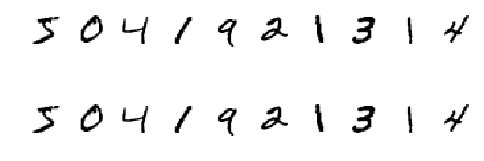

In [17]:
plt.figure(figsize=[8,3])

for i in range(10):
    r = vae.predict(X_train[[i]])

    plt.subplot(2,10,1+i)
    plt.imshow(X_train[i,:,:,0], vmax=1, vmin=0, cmap='gray_r')
    plt.axis('off')

    plt.subplot(2,10,11+i)
    plt.imshow(r[0,:,:,0], vmax=1, vmin=0, cmap='gray_r')
    plt.axis('off')

### 시각화

In [21]:
model2 = Model(input, [z_mean, z_log_var])

In [29]:
latent_value = model2.predict(X_train[:100])

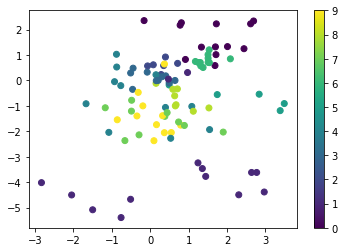

In [31]:
plt.scatter(latent_value[0][:,0], latent_value[0][:,1], c=y_train[:100])
plt.colorbar()

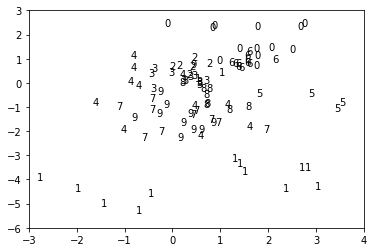

In [32]:
plt.axis([-3,4,-6,3])
for i in range(100):
    plt.text(latent_value[0][i,0], latent_value[0][i,1], str(y_train[i]))